<h1><center> Business Data Science:  Text mining use-case </center></h1>

## Definitions: 

1. **Input Features** are the variables that are provided to the model to learn from. In a modeling context, the **Target** is what we are trying to predict / approximate. 


2. The goal of **Text mining** is to pull relevant information from textual data, such as keywords, text summaries, and sentiment classification.


3. **Text classification** involves taking a text representation as input and predicting the associated class based on the context described in the text. For example: classify a tweet as positive or negative. 


## Objectives

The objective of this study is to predict the customer's intention (Target) based on the transcript of his call. 

We classify the intentions into five main categories:

  - Confirm
  - Infirm      
  - NewAppointment
  - Propose      
  - Transfer       

The client calls consist of a free request, i.e. without the constraint of using a particular vocabulary or format, in French. Here are some examples of such requests, in *verbatim* form, and the corresponding intentions: 

  - "ok ben oui ça ira"                              (Confirm)
  - "c est un peu tôt"                               (Infirm)
  - "alors ça se serait pour prendre rendez-vous"    (NewAppointment)
  - "si c est possible je préférerais plutôt $TIME$" (Propose)
  - "je veux pas parler à un robot"                  (Transfer)
  
The purpose of this study is to automatically predict the intention from the verbatim of the request. For that, we rely on an annotated database containing examples of verbatim and associated intentions.


### Learning objectives

By the end of this notebook, you will learn: 
    
    - Process and Clean text data. 
    
    - Prepare and Transform text data in the correct format required by machine learning classification models. 
    
    - Define the suppervised training pipeline: 

       Inputs preparation > model definition > cross-validation process > model's scoring > performance comparison

In [37]:
import warnings
warnings.filterwarnings('ignore')

## I. Setup and Data loading

In [38]:
import os 
datadir = os.getcwd() # Get the path of the current working directory.
datafile= 'calldesk-intents.txt' # name of the data file that exist in the same directory of the notebook. 

In [39]:
import pandas as pd
data = pd.read_csv(datafile , header=None, encoding="utf-8").squeeze()

Note here the `squeeze` operator transforms a `pandas.DataFrame` into a `pandas.Series`, which is not required but useful since the data has only one column at this stage.

In [40]:
data.head()

0                                  Confirm OK
1                          Confirm absolument
2    Confirm ah oui ça c est bien ça comme ça
3                               Confirm aller
4         Confirm allez c est bon pour $TIME$
Name: 0, dtype: object

We observe that each row consists of a text sentence where the first term provides the intention class and the following words correpond to the verbatim.  

So we will separate the two components and to generate two columns: `verbatim` and `intent`. The result is grouped in a single structure: `df`, of type `pandas.DataFrame`.


In [41]:
df = pd.DataFrame()
df['intent'] = data.apply(lambda l : l.split(' ', 1)[0].strip())
df['verbatim'] = data.apply(lambda l : l.split(' ', 1)[1].strip())

### Distribution of target variable 

In [42]:
df.head()

,intent,verbatim
0,Confirm,OK
1,Confirm,absolument
2,Confirm,ah oui ça c est bien ça comme ça
3,Confirm,aller
4,Confirm,allez c est bon pour $TIME$


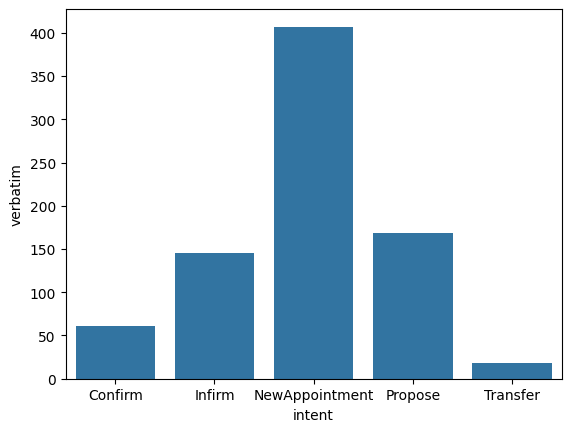

In [43]:
import seaborn as sns
%matplotlib inline
intents = df.groupby('intent').count().reset_index()
sns.barplot(x='intent', y ='verbatim', data=intents);

We notice that the `NewAppointment` class is in the most present one. On the other hand, the class `Transfer` is under represented. We have to take into account this unbalanced distribution in the training and evaluation of our different models. 


## II. Data pre-processing

- **(1)** The first step is to clean the sentences from special characters and punctiations as they won't impact the intention classification. 

In [44]:
import re
# function to clean the text and separate the juntion between joined words 
def clean_str(verbatim):
    """
    Remove / process scpecial characters from each verbatim
    """
    verbatim = re.sub(r"[-,!?\'\`]", " ", verbatim)
    verbatim = re.sub(r"\'s", " \'s", verbatim)
    verbatim = re.sub(r"\'ve", " \'ve", verbatim)
    verbatim = re.sub(r"n\'t", " n\'t", verbatim)
    verbatim = re.sub(r"\'re", " \'re", verbatim)
    verbatim = re.sub(r"\'d", " \'d", verbatim)
    verbatim = re.sub(r"\'ll", " \'ll", verbatim)
    verbatim = re.sub(r",", " , ", verbatim)
    verbatim = re.sub(r"!", " ! ", verbatim)
    verbatim = re.sub(r"\(", " \( ", verbatim)
    verbatim = re.sub(r"\)", " \) ", verbatim)
    verbatim = re.sub(r"\?", " \? ", verbatim)
    verbatim = re.sub(r"\s{2,}", " ", verbatim)
    return verbatim.lower()

df['verbatim']= df['verbatim'].apply(clean_str)

- **(2)** The second step consists of converting each sentence to a list of words, this operation is often referred to as **Tokenization**. 

    * The straightfoward solution is to use the python operator `.split(" ")` that will detects white spaces between words and split. 
    
    * For more sophisticated segmentation, we can use the method <a href="https://www.guru99.com/tokenize-words-sentences-nltk.html">method</a>  provived by the **nltk package**. This method is able to break down sentence into a list of words even when a white space is ommitted. 



In [45]:
df['segmented_verbatim'] = [s.strip().split() for s in df['verbatim']]

In [46]:
df.head()

,intent,verbatim,segmented_verbatim
0,Confirm,ok,[ok]
1,Confirm,absolument,[absolument]
2,Confirm,ah oui ça c est bien ça comme ça,"[ah, oui, ça, c, est, bien, ça, comme, ça]"
3,Confirm,aller,[aller]
4,Confirm,allez c est bon pour $time$,"[allez, c, est, bon, pour, $time$]"


* **(3)** The third step is to remove stopwords that are often used for syntax and are not informative for the intention classification task. Example of french stopwords are : `de`, `la`, and `dont`, etc. The nltk package  contains an exhaustive list that can be retrieved from `nltk.corpus.stopwords`.

In [47]:
# install the nltk package
!pip install nltk

In [48]:
import nltk
# download the list of stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rahimi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [49]:
# Get the list of stop_words :
from nltk.corpus import stopwords
list_stopwords = list(set(stopwords.words('french')))
list_stopwords[50:55]

['furent', 'pas', 'la', 'aurai', 'avons']

- For each row of the dataframe, we will remove the stopwords from the list of `segmented_verbatim`. `pandas.DataFrame` offers an `apply` method that enables us to apply a `function` to each row entry. 

In [50]:
def remove_stopwords(segmented_verbatim):
    return [w for w in segmented_verbatim if w.lower() not in list_stopwords]
    
# Remove the stopwords from the segmented verbatims
df['segmented_verbatim'] = df['segmented_verbatim'].apply(remove_stopwords)

In [51]:
df.head(6)

,intent,verbatim,segmented_verbatim
0,Confirm,ok,[ok]
1,Confirm,absolument,[absolument]
2,Confirm,ah oui ça c est bien ça comme ça,"[ah, oui, ça, bien, ça, comme, ça]"
3,Confirm,aller,[aller]
4,Confirm,allez c est bon pour $time$,"[allez, bon, $time$]"
5,Confirm,alors ça c est bien,"[alors, ça, bien]"


- **(4)** The fourth step is **Stemming** that normalizes words by retaining only their roots. By eliminating plurals, conjugations, etc., you reduce noise while preserving the original meaning. `nltk` package offers a french-based algorithm that automatically extracts the root of each word: 

In [52]:
from nltk.stem.snowball import SnowballStemmer

def word_stemmer(words):
    snowball = SnowballStemmer('french') #
    preprocessed_text = [snowball.stem(word) for word in words]
    return preprocessed_text

# Extract roots from the verbatim word 
df['segmented_verbatim_root'] = df['segmented_verbatim'].apply(word_stemmer)

In [53]:
df.head(10)

,intent,verbatim,segmented_verbatim,segmented_verbatim_root
0,Confirm,ok,[ok],[ok]
1,Confirm,absolument,[absolument],[absolu]
2,Confirm,ah oui ça c est bien ça comme ça,"[ah, oui, ça, bien, ça, comme, ça]","[ah, oui, ça, bien, ça, comm, ça]"
3,Confirm,aller,[aller],[aller]
4,Confirm,allez c est bon pour $time$,"[allez, bon, $time$]","[allez, bon, $time$]"
5,Confirm,alors ça c est bien,"[alors, ça, bien]","[alor, ça, bien]"
6,Confirm,bah oui voila,"[bah, oui, voila]","[bah, oui, voil]"
7,Confirm,ben oui si il y a que ça,"[ben, oui, si, a, ça]","[ben, oui, si, a, ça]"
8,Confirm,bon bah oui,"[bon, bah, oui]","[bon, bah, oui]"
9,Confirm,bon d accord,"[bon, accord]","[bon, accord]"


## III. Vectorized representation of the verbatims

Most Machine Learning techniques work on vector data with numerical values. The step that consists in transforming the words of the verbatims and the verbatims themselves into vectors is therefore fundamental. 

In what follows, we will highlight different ways, from the least sophisticated to the most sophisticated one, to perform this vectorization step.

### Bag of words representation

- The simplest method to vectorize a verbatims is based on counting the number of occurrences of each word.


- More precisely, we consider the set of words appearing in the database, which we call *dictionary* and note as $\mathcal{D} = (w_j)$, where $w_j$ is the j-th word of the dictionary. Afterward, we encode each verbatim as a vector, where the non-zero entries correspond to the index of the words and the values to their frequencies.


- Example: Let's take as an example the following verbatim ``ok ben oui ça ira``. It is composed by the following words:


 <center>$w_{109}$="ok" ||  $w_{144}$="ben" ||  $w_{128}$="oui" || $w_{135}$="ça" || $w_{195}$="ira"</center>


    ==> The corresponding representation of the verbatim is a vector of integers of length 265 (the total number of unique words): [0, 0 ,...., 1, ....0]; All values are zeros but the ones related to indices `109`, `144`, `128`, `135` and `195`. 

- **Bag of Words**:  consists of applying this transformation to the whole set of verbatims allow us to define the representation matrix $M=(m_{ij})$,where the $m_{i,j}$ entry corresponds to the occurence of word $w_j$ within the `i-th` verbatim.  






In [54]:
import collections
import numpy as np
np.random.seed(4)
def count_words(texts):
    """Vectorize the text : return count of each word in the text snippets
        
        Parameters
        ----------
            texts: List[strings] 
                The list of texts, where each text is represented as a sequence of words. 
        
        Returns
        -------
            vocabulary : dict
                A dictionary that points to an index in counts for each word.
        
            counts : ndarray, shape (n_samples, n_features)
                Convert each word in the text to its corresponding frequency
        
        We note that: 
            n_samples refers to the number of documents.
        
            n_features refers to the number of unique words in vocabulary.
    """
    # Create the list of unique words : 
    unique_words = set([val for t in texts for val in t])  
    
    n = len(unique_words)
    
    # Instantiate the vocabulary of words
    vocabulary = dict(zip(unique_words, range(n)))
    
    # Create the bag of word representation for each document
    bagofwords = [collections.Counter(text) for text in texts]
    
    
    cardinality = len(texts)
    
    #Create the ndarray counts : 
    count = np.zeros((cardinality, n))

    for i in range(cardinality):
        count[i] = [bagofwords[i][x] for x in unique_words]
        
    return vocabulary, count

In [55]:
vocabulary, count_matrix = count_words(df['segmented_verbatim_root'])
len(vocabulary), count_matrix.shape

(227, (800, 227))

In [56]:
vocabulary

{'sais': 0,
 'fais': 1,
 'pris': 2,
 'ok': 3,
 'impossibl': 4,
 'bah': 5,
 'mal': 6,
 'va': 7,
 'docteur': 8,
 'jour': 9,
 'car': 10,
 'delaplac': 11,
 'mieux': 12,
 'obten': 13,
 'ben': 14,
 'rend': 15,
 'sor': 16,
 'sup': 17,
 'martin': 18,
 'revien': 19,
 'ah': 20,
 'alor': 21,
 'dans': 22,
 'reprend': 23,
 'don': 24,
 'humain': 25,
 'absolu': 26,
 'voilà': 27,
 'tres': 28,
 'vacanc': 29,
 'désol': 30,
 'échograph': 31,
 'hasard': 32,
 'irai': 33,
 'chez': 34,
 'visit': 35,
 'attend': 36,
 'ajout': 37,
 'voir': 38,
 'disponibl': 39,
 'hein': 40,
 'picard': 41,
 'madam': 42,
 'bon': 43,
 'rien': 44,
 'okay': 45,
 'tim': 46,
 'ça': 47,
 'truc': 48,
 'nouveau': 49,
 'arrang': 50,
 'mid': 51,
 'uniqu': 52,
 'oui': 53,
 'jam': 54,
 'journ': 55,
 'tromp': 56,
 'pens': 57,
 'souhait': 58,
 'relat': 59,
 'tout': 60,
 'piscin': 61,
 'libr': 62,
 'consult': 63,
 'horair': 64,
 'vas': 65,
 'créneau': 66,
 'mis': 67,
 'pass': 68,
 'envoi': 69,
 'secrétariat': 70,
 'quelqu': 71,
 'peu': 72,
 'pl

The `vocabulary` represents the set of all possible words (265), i.e. the dictionary and `count_matrix` corresponds to the `Bag of Words` matrix grouping the numerical representation of verbatims.

#### Filter out rare and very frequent words 

We may also want to filter out words that are too rare or too frequent: 

    - A  rare word will not bring any information on the intention because it will not have been observed enough to be significantly associated with an intention.
    
    - A  frequent word may not be informative either because it appears everywhere (~empty word). 

The ``CountVectorizer`` function provided by the `sklearn` package offers this filter option. 

In [57]:
from sklearn.feature_extraction.text import CountVectorizer
def count_words_filter(texts, max_df,min_df):
    """Vectorize text : return count of each word in the text snippets
    Parameters
    ----------
    texts : list of str
        The texts (documents)
    max_df : eliminate the words with a relative frequency higher than max_df (to eliminate frequent terms)
    min_df : eliminate the words with a relative frequency less than min_df (to eliminate the rare words)

    Returns
    -------
    vocabulary : array that contains the list of words.
    counts : ndarray, shape (n_samples, n_features) : sparse matrix 
        The counts of each word in each text.
        n_samples == number of documents.
        n_features == number of words in vocabulary.
    """
    #texts = map(clean_text,texts)  #----if the text is not already cleaned 
    vectorizer = CountVectorizer(max_df=max_df, min_df=min_df, analyzer=lambda x: x)
    counts = vectorizer.fit_transform(texts)
    vocabulary = vectorizer.get_feature_names_out()
    return  vocabulary,counts

In [58]:
min_freq = 3/800
max_freq = 0.4
filtered_vocabulary, filtered_count_matrix = count_words_filter(df['segmented_verbatim_root'], max_freq, min_freq )
len(filtered_vocabulary), filtered_count_matrix.shape

(97, (800, 97))

### Vector representation based on the words co-occurence 


- Unlike the Bag of Words representation defined above which is based on the "word-verbatim" relation, we will define a co-occurrence matrix of size n x n (where n represents the size of the dictionary).


- In this method, we fix a context window $w$. Then for each word in the database we will compute the number of occurrences of the neighboring words (i.e., words that appear in the same window). The resulting matrix
$$C = (c_{jk})$$ represents the frequency of the word $k$ in the neighborhood of the word $j$ (we do not go into the details of the frequency computation which involves a ponderation term based on how far the word $k$ is to word $j$)


- To build shuch matrix we will use the package `scipy` that is optimization for all matrix operations

In [59]:
import scipy
def build_cooccur(vocab, corpus, window_size=10, min_count=None):
    """
    Build the co-occurence matrix 
    Patamers: 
    --------
        vocab : dictionnary that contains all the words present in the database 
        corpus : list of tokenized verbatim
        window_size : the size of the context window 
        min_count : frquency threshold to eliminate rare words. 
    """
    
    vocab_size = len(vocab)
    
    # Collect cooccurrences internally as a sparse matrix forindexing speed;
    cooccurrences = scipy.sparse.lil_matrix((vocab_size, vocab_size),
                                      dtype=np.float64)
    #Construct word vectors
    for tokens in corpus:
        toknbs = len(tokens)
        token_ids = [vocab[word] for word in tokens]
        for i in range(toknbs):
            
            for j in range(1,window_size + 1):
                increment = 1. / j
                if (i+j < toknbs):
                    cooccurrences[token_ids[i], token_ids[i+j]] += increment
                    cooccurrences[token_ids[i+j], token_ids[i]] += increment
                if (i-j >=0):
                    cooccurrences[token_ids[i], token_ids[i-j]] += increment
                    cooccurrences[token_ids[i-j], token_ids[i]] += increment
                
    return cooccurrences

In [60]:
cooccurence = build_cooccur(vocabulary, df['segmented_verbatim_root'], window_size=3, min_count=2)
cooccurence

<List of Lists sparse matrix of dtype 'float64'
	with 2010 stored elements and shape (227, 227)>

- Let's take the example of the two words `dame` and `petite`:

In [61]:
cooccurence[vocabulary['dam'], vocabulary['petit']]

2.0

- `2` means that the words `dame` and `petites` co-occurs in average within a distance of 2 positions.  

- Generate the words representation vectors

###  [Advanced] Deep Learning-Based representation:  Word2Vec

- Instead of building the co-occurrence matrix and learn to compress the information using Glove, we will create a predictive model trained to learn to represent the words in our database. The basic idea of the Word2Vec model (Continuous Bag of Word variant) is to use a shallow neural network to predict a central work given all surrounding context. 
- The resulting representation contains the syntax and semantic information of each word such as similar words will have close vectors. 

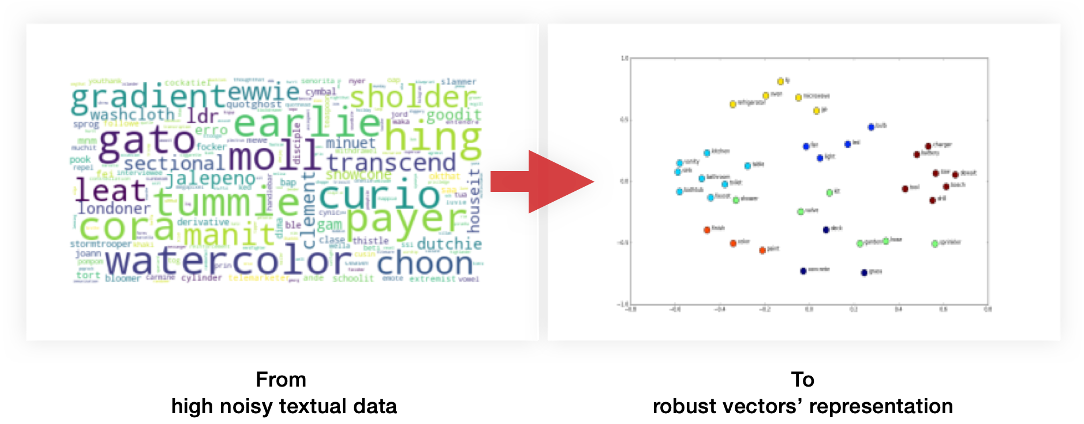

Train word2vec using the verbatims text:

In [62]:
from gensim.models import word2vec
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
# Set values for various parameters
num_features = 265    # Word vector dimensionality                      
min_word_count = 1   # Minimum word count                        
num_workers = 1       # Number of threads to run in parallel
context = 2         # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words
model_w2v = word2vec.Word2Vec(df['segmented_verbatim_root'].values, workers=num_workers, vector_size=num_features,
                          min_count = min_word_count, window = context, sample = downsampling)

ModuleNotFoundError: No module named 'gensim'

In [ ]:
model_w2v.init_sims(replace=True)

2024-07-06 15:14:05,317 : WARNING : destructive init_sims(replace=True) deprecated & no longer required for space-efficiency


Visualize the vector representation of the word `dame`

In [ ]:
model_w2v.wv["dam"]

array([ 3.97131182e-02, -8.41231346e-02, -4.03604954e-02,  9.11917686e-02,
       -2.98094400e-03,  9.54267532e-02,  9.15641040e-02, -2.18549725e-02,
       -1.49892904e-02,  4.87689041e-02,  7.63601437e-02,  1.08687565e-01,
        6.87516853e-02, -3.80151868e-02, -7.20075667e-02, -6.94709942e-02,
        2.42776610e-02, -5.80891408e-02, -3.23809497e-02, -8.48593377e-03,
        5.59974238e-02,  7.99627528e-02,  5.66032343e-02, -2.07975246e-02,
       -1.14075929e-01, -1.35684572e-02,  7.51154497e-02, -6.95128664e-02,
        7.94869736e-02,  1.52961360e-02,  2.50406265e-02, -2.97609773e-02,
       -1.30312014e-02,  2.71620080e-02,  3.07566989e-02,  6.62921295e-02,
       -8.46243054e-02, -2.67700781e-03,  1.08468942e-01,  7.10406974e-02,
       -6.01702929e-02,  3.80731896e-02, -1.60645321e-02,  5.81581146e-02,
        3.15206964e-03,  3.74664739e-02, -6.16533905e-02, -6.15138300e-02,
        5.26980907e-02, -6.57389536e-02,  2.06739772e-02,  9.44322050e-02,
        5.07578291e-02,  

In [ ]:
model_w2v.wv.most_similar('transfer')

[('rend', 0.38457268476486206),
 ('$time$', 0.3792353868484497),
 ('non', 0.35636967420578003),
 ('prendr', 0.32253745198249817),
 ('ven', 0.282888263463974),
 ('plutôt', 0.2643870413303375),
 ('tard', 0.2590874433517456),
 ('va', 0.24365194141864777),
 ('nouveau', 0.23844270408153534),
 ('souhait', 0.23644672334194183)]

- Generates the dictionary of words representation vectors

In [ ]:
word2vec_dict = dict(zip(model_w2v.wv.index_to_key, model_w2v.wv))

## IV. Intention classification 

This section aims to evaluate the performance of the different representations, discussed in the previous section,when used in combination with different classification models. 

### a. Verbatim representation models

- We define two functions that allow us to construct the representation of a verbatim from the vectors of the words that make it up. 

In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter, defaultdict
class MeanEmbeddingVectorizer(object):
    """
    Verbatim is representent by the average of words embeddings. 
    """
    def __init__(self, word2vec):
        """
        word2vec: a dictionary where each word is mapped to its vector representation.
        """
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

class TfidfEmbeddingVectorizer(object):
    """
    Verbatim is representent by the weighted (words frequency) average of words embeddings. 
    """
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

- Example: 

In [64]:
model = TfidfEmbeddingVectorizer(word2vec_dict).fit(df['segmented_verbatim_root'], df['intent'])
verbatim_vector = model.transform(['allez', 'bon',  '𝑡𝑖𝑚𝑒'])
verbatim_vector.shape

NameError: name 'word2vec_dict' is not defined

### b. Input matrices 

We consider three different representation of the input verbatims:

   - **input_bow:** each entry $c_{i,j}$ corresponds to the frequence of word i in verbatim j. 
   
   
   - **input_bow_tfidf** The frequency  $c_{i,j}$ is corrected by the present ratio of the word $i$ in the whole set of verbatims 
  

   - **input_w2v_average:** A matrix $W$ of shape 800x337 where the representation of verbatim $j$ is computed as the average over all its words vectors. 
   
   
   - **input_w2v_tfidf:**  the representation of the verbatim is given as a weighted average of the words vectors (The correction is based on the fequency ratio of the word within the whole set of verbatims)


In [48]:
raw_input_data = df['segmented_verbatim_root']
target = df['intent']

In [50]:
input_bow_tfidf = TfidfVectorizer(analyzer=lambda x: x).fit(raw_input_data, target).transform(raw_input_data)
input_w2v_average = MeanEmbeddingVectorizer(word2vec_dict).fit(raw_input_data, target).transform(raw_input_data)
input_w2v_tfidf = TfidfEmbeddingVectorizer(word2vec_dict).fit(raw_input_data, target).transform(raw_input_data)

# Aggregate all the matrix defined previously 
input_matrices = {
    'bow' : count_matrix,
    'bow_tfidf' : input_bow_tfidf,
    'w2v_average' : input_w2v_average,
    'w2v_tfidf' : input_w2v_tfidf,
    }

### c. Classification models

* During this section, we will list all machine learning algorithms for text classification and apply them to the different methods of feature representation.

        - knn 
        - Naive Bayes:  Bernoulli & Multinomial 
        - SVC 
        - Extra-trees
        - Random Forest
        - Regression logistique
     

In [52]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
# dictionnay of models 
classification_models = {
    "extra trees":  ExtraTreesClassifier(n_estimators=300),
    "multinomial nb": MultinomialNB(),
    "bernoulli nb": BernoulliNB(),
    "linear svc": SVC(kernel="linear"), 
    "LR" : LogisticRegression(),
    "Random forest": RandomForestClassifier(),  
    "k-nn": KNeighborsClassifier(n_neighbors=2)
}

### d. Model Training 

In this section, we will train the pairs of  (input representation, classification model)

- To compare the different methods, we would use the following <a href=https://towardsdatascience.com/multi-class-metrics-made-simple-part-ii-the-f1-score-ebe8b2c2ca1> multi-classification scores </a>:  


    * Precision: What is the proportion of the positives that were correctly predicted by the model?
$$Precision = \frac{TP}{TP+FP}$$

    * Recall: What proportion of predicted positives retrieved by the model are truly positives?
$$Recall = \frac{TP}{TP+FN}$$
   
    * F1-score: Ensure the trade-off between Recall and Precision.  
$$F1\_score = 2 \times \frac{precision \times recall}{precision+recall}$$


- Let's run the cross-valivation experiments that for each pair of (input, model) launches a training iteration using 80% of the data and compute the validation `F1-score` on the remaining 20%

In [59]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
np.random.seed(42)
scores = {}
for name, data in input_matrices.items(): 
    scores[name] = {}
    for clf, model in classification_models.items():
        try: 
            cross = cross_val_score(model, data, target, cv=5, scoring='accuracy')
            scores[name][clf] = (cross.mean(), cross.std()*2)
        except:
            pass

In [55]:
l = []
for k in scores.keys(): 
    data_scores = pd.DataFrame({'data_input': k ,'model' : p , 'score': v[0]} for p, v in scores[k].items())
    l.append(data_scores)
scores_frame = pd.concat(l)
scores_frame.head()

,data_input,model,score
0,bow,extra trees,0.91500
1,bow,multinomial nb,0.90125
2,bow,bernoulli nb,0.89750
3,bow,linear svc,0.90875
4,bow,LR,0.92000


- We can visualize the scores of all tested pairs to compare the methods:

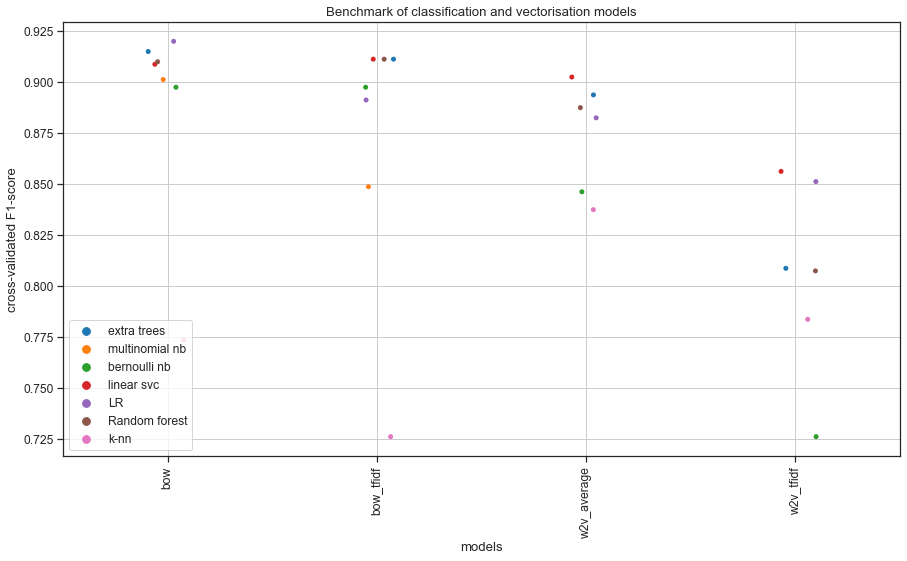

In [56]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")
sns.stripplot('data_input', 'score', 
           data=scores_frame, 
           hue="model" )
plt.xticks(rotation='vertical')
plt.title('Benchmark of classification and vectorisation models')
plt.xlabel('models')
plt.ylabel('cross-validated F1-score')
plt.legend(loc='lower left')
plt.grid()

**Conclusions:** 
- Best performance score is achieved for:  **LR + bow**.

- Machine learning methods fail to detect the semantic relationship contained in deep vectors constructed from Glove or word2vec models. 


### e. Learning curve:  Training evolution 

- Function to compute Precision and F1-score at each iteration

In [57]:
from sklearn.metrics import f1_score, precision_score
def train_benchmark_F1(model, X, y, n):
    test_size = 1 - (n / float(len(y)))
    scores = []
    for train, test in StratifiedShuffleSplit(n_splits=5, test_size=test_size).split(X, y):
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]
        scores.append(f1_score(model.fit(X_train, y_train).predict(X_test), y_test, average='weighted'))
    return np.mean(scores), np.std(scores) * 2

def train_benchmark_precision(model, X, y, n):
    test_size = 1 - (n / float(len(y)))
    scores = []
    for train, test in StratifiedShuffleSplit(n_splits=5, test_size=test_size).split(X, y):
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]
        scores.append(precision_score(model.fit(X_train, y_train).predict(X_test), y_test, average='weighted'))
    return np.mean(scores), np.std(scores) * 2

- Gather the scores with different training sizes: 10, 40, 160, 320, 640, 750 and 800: 

In [58]:
train_sizes = [10, 40, 160, 320, 640, 750, 800]
table = []
for name, data in input_matrices.items(): 
    for clf, model in classification_models.items():
        #print('getting score for the classifier:', clf,'and the data input:', name)
        for n in train_sizes:
            try:
                table.append({'model': clf, 
                              'precision': train_benchmark_F1(model, data, target, n),
                              'F1-score' : train_benchmark_precision(model, data, target, n),
                              'train_size': n,
                              'data_input': name,
                             })
            except:
                pass
            
results  = pd.DataFrame(table)

Let's vizualize the learning curve: 

2024-05-20 16:50:57,811 : INFO : NumExpr defaulting to 8 threads.


[Text(0, 0.5, 'Precision score')]

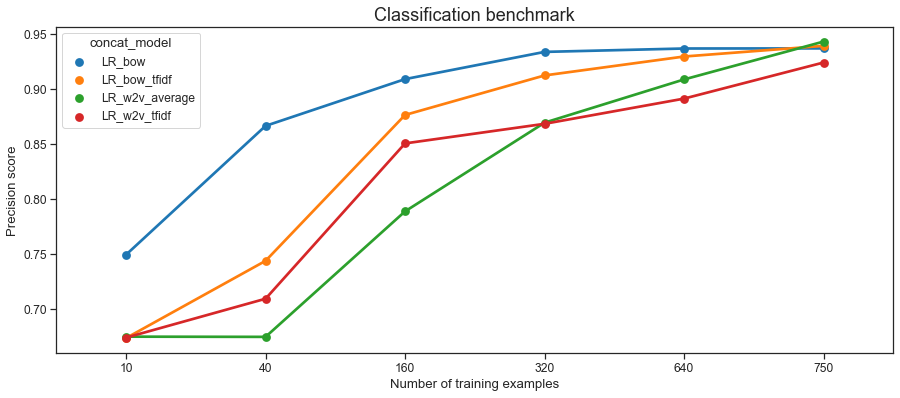

In [56]:
import seaborn as sns 
from matplotlib import pyplot as plt
%matplotlib inline 

# prepare columns to visualize 
results['prec'] = results['precision'].map(lambda x: x[0])
results['std_p'] = results['precision'].map(lambda x: x[1])
results['f1'] = results['F1-score'].map(lambda x: x[0])
results['std_f'] = results['F1-score'].map(lambda x: x[1])
results.drop('F1-score', axis=1, inplace=True)
results.drop('precision', axis=1, inplace=True)
results['concat_model'] = results['model']+'_'+results['data_input']

# Define the vizualization plot
plt.figure(figsize=(15, 6))
fig = sns.pointplot(x='train_size', y='prec', hue='concat_model', 
                    data=results[results.concat_model.map(lambda x : x in [ 'LR_bow', 
                                                                            'LR_bow_tfidf',
                                                                            'LR_w2v_average',
                                                                            'LR_w2v_tfidf'
                                                                          ])])
sns.set_context("notebook", font_scale=1.5)
fig.set(ylabel="accuracy")
fig.set(xlabel="Number of training examples")
fig.set(title="Classification benchmark")
fig.set(ylabel="Precision score")

This is the end of the use-case. You successfully

- Performed text cleaning with regex and nltk
- Represent words with different techniques: frequency-based and prediction model-based
- Trained various machine learning algorithm for text classification with scikit-learn
- Visualized prediction scores with seaborn and matplotlib. 